# Quant GAN
## Torch Verison
[Wiese et al., Quant GANs: Deep Generation of Financial Time Series, 2019](https://arxiv.org/abs/1907.06673)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from preprocess.acf import *
from preprocess.gaussianize import *

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from model.torch_tcn import *
import os, sys
generator_path = f'/content/temporalCN/trained/'
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

device = torch.device(dev) 

In [3]:
#retrieve and store ticker data
def get_data(tickers):
    #storing ticker in dictionary for convenience 
    ticker_data ={}
    start_date = "2016-06-01"
    end_date = "2019-06-01"
    
    #iterating through ticker list
    for ticker in tickers:
        ticker_object = yf.Ticker(ticker)
        historical_data = ticker_object.history(start=start_date, end=end_date, interval="1d")
        ticker_data[str(ticker)] = historical_data['Close']
        
    return ticker_data

In [4]:
#test
tickers = ['SPY', 'AAPL', 'TLT']
data = get_data(tickers)

In [5]:
#change type to df for extraction (and convenience) in a new cell so don't have to download data each time
data = pd.DataFrame(data=data)

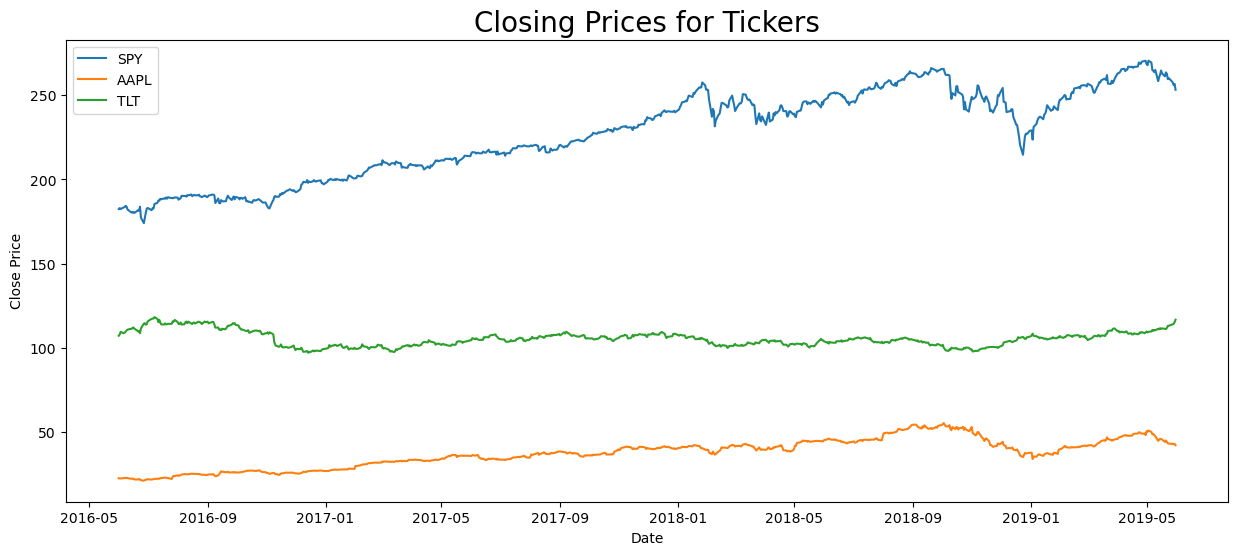

In [6]:

def dateparse(d):
    return pd.Timestamp(d)

fig = plt.figure(figsize=(15,6))
plt.title('Closing Prices for Tickers', fontsize=20)
for ticker in data.columns:
    plt.plot(data.index, data[ticker], label=ticker)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
# confirm data loaded

## Preprocess data
 For more details see [preprocess.ipynb](./preprocess.ipynb)

In [7]:
class Loader32(Dataset):
    
    def __init__(self, data, length):
        assert len(data) >= length
        self.data = data
        self.length = length
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx+self.length]).reshape(-1, self.length).to(torch.float32)
        
    def __len__(self):
        return max(len(self.data)-self.length, 0)

returns = data.shift(1)/data - 1
log_returns = np.log(data/data.shift(1))[1:].to_numpy().reshape(-1, 3)
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()
log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))
receptive_field_size = 127  # p. 17
data_size = log_returns.shape
print(data_size)


(754, 3)


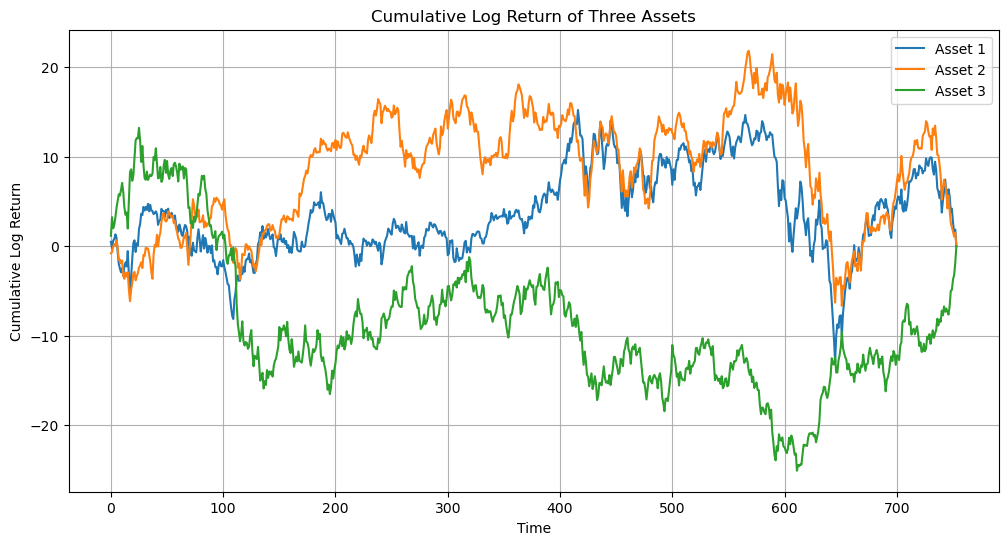

In [8]:
cumulative_log_return_all = np.cumsum(log_returns_preprocessed, axis=0)
cumulative_log_return = cumulative_log_return_all[:]
plt.figure(figsize=(12, 6))
plt.plot(cumulative_log_return)
plt.title('Cumulative Log Return of Three Assets')
plt.xlabel('Time')
plt.ylabel('Cumulative Log Return')
plt.legend(['Asset 1', 'Asset 2', 'Asset 3'])
plt.grid(True)
plt.show()


In [9]:
def generate_distributions(ticker_list):
    pass
        

## Train model
 For more details see [torch_model.ipynb](./torch_model.ipynb)

In [38]:
import importlib
from model import torch_tcn
importlib.reload(torch_tcn)
from model.torch_tcn import Generator, Discriminator
num_epochs = 15
nz = 80
batch_size = 1
seq_len = 127
clip= 0.01
lr = 0.00003

#conditional window
context_len = 100
indx=101

In [30]:
#tests
contextset = Loader32(log_returns_preprocessed,  context_len)
dataset = Loader32(log_returns_preprocessed, length=context_len)
generator = Generator().to("cpu")
total_len = context_len + seq_len
discriminator = Discriminator(seq_len=total_len)


if indx>= context_len:
    data = dataset[indx]
    context = dataset[indx].reshape(-1, 3, context_len)
    context_broadcast = context.repeat(batch_size,1,1)
    #append to noise with broadcasting
    noise = torch.randn(batch_size, 3, seq_len, device=device) #batch_size, nz, seq_len, device=device
    cond_noise = torch.cat((context_broadcast, noise), axis=2)
    print(cond_noise.shape)
else:
    print("LengthError: Index must be greater than context length")

discinput = torch.mean(discriminator(cond_noise))


torch.Size([1, 3, 227])


c:\Users\juanp\anaconda3\envs\GAN_1\lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [39]:
#Todo: wrap conditional statement around conditional noise to make sure idx>context length
import torch.optim as optim
from tqdm import tqdm
generator = Generator().to(device)

train = True

if train:
    context_len = 50
    #initiates discriminator object
    discriminator = Discriminator((seq_len+context_len)).to(device)

    #defines optimizers for discriminator and generator
    disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr)
    gen_optimizer = optim.RMSprop(generator.parameters(), lr=lr)

    #initiates dataset and dataloader classes for model handling of data
    dataset = Loader32(log_returns_preprocessed, seq_len)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    #separate contextset which loads returns of context_len
    contextset = Loader32(log_returns_preprocessed,  context_len)

    #creates a progress bar
    t = tqdm(range(num_epochs))
    #training cycle
    for epoch in t:
    
        #single iteration
        for idx, data in enumerate(dataloader, context_len):
            
            #starts at the index of the context length otherwise it doesn't have any data to grab
            discriminator.zero_grad()
            real = data.to(device)

            #context = tensor containing data[index - context_length: index] of length context_len hence why contextset is used
            context = contextset[idx-context_len].reshape(-1,3,context_len).to(torch.float32) #might have to substract 1 from idx-contextlength to not give out present info
            
            #match on dim[0] so it can concatenate
            context_broadcast = context.repeat(batch_size,1,1)
            noise = torch.randn(batch_size, 3, seq_len, device=device) #batch_size, nz, seq_len, device=device

            #concatenate context and noise, context and real
            cond_noise = torch.cat((context_broadcast, noise), axis=2)
            realandcontext = torch.cat((context, real), axis=2)

            fake = generator(cond_noise).detach()
            disc_loss = -torch.mean(discriminator(realandcontext)) + torch.mean(discriminator(cond_noise))
            disc_loss.backward()
            disc_optimizer.step()

            for dp in discriminator.parameters():
                dp.data.clamp_(-clip, clip)
    
            if idx % 15 == 0:
                generator.zero_grad()
                gen_loss = -torch.mean(discriminator(generator(cond_noise)))    
                gen_loss.backward()
                gen_optimizer.step()            
        t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))
            
    # Save
    torch.save(generator, f'conditional_{num_epochs}epochs_v0.0.pth')

Discriminator Loss: -0.00001150 Generator Loss: -0.50160843: 100%|██████████| 15/15 [08:37<00:00, 34.50s/it]


### Generate

In [40]:
# generator = torch.load("conditional_5epochs_v0.0.pth")
generator.eval()
y = generator(cond_noise).cpu().detach().squeeze()

# Reshape y to (batch_size * length, 3) before applying scaling
y_reshaped = y.reshape(-1, 3)

# Apply the transformations
y_reshaped = (y_reshaped - y_reshaped.mean(axis=0)) / y_reshaped.std(axis=0)
y_reshaped = standardScaler2.inverse_transform(y_reshaped)
y_reshaped = np.array([gaussianize.inverse_transform(x.reshape(-1, 1)).flatten() for x in y_reshaped.T]).T
y_reshaped = standardScaler1.inverse_transform(y_reshaped)

# Reshape back to (batch_size, 3, length)
y = y_reshaped.reshape(3, -1, y.shape[-1]).transpose(1, 0, 2)

# some basic filtering to reduce the tendency of GAN to produce extreme returns
# y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
# y -= y.mean()

y.shape


(1, 3, 177)

In [41]:
xxx=0

## Results and visualizing stylized facts

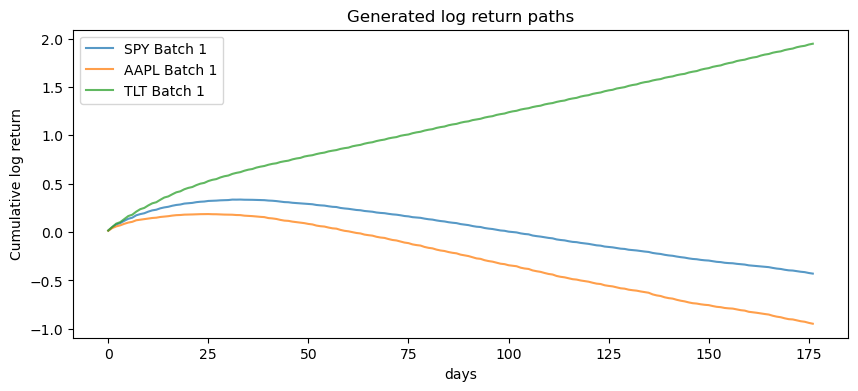

In [42]:
# fig, ax = plt.subplots(figsize=(16,9))
# ax.plot(np.cumsum(y[0:3], axis=1).T, alpha=0.75)
# ax.set_title('30 generated log return paths'.format(len(y)))
# ax.set_xlabel('days')
# ax.set_ylabel('Cumalative log return')


fig, ax = plt.subplots(figsize=(10, 4))

# Loop through the first 3 batches
for i in range(xxx,xxx+1):
    for j in range(3):  # Loop through each asset
        if j == 0:
            asset = "SPY"
        elif j==1:
            asset = "AAPL"
        elif j==2:
            asset = "TLT"
        ax.plot(np.cumsum(y[i, j, :]), alpha=0.75, label=f'{asset} Batch {i + 1}')

ax.set_title('Generated log return paths')
ax.set_xlabel('days')
ax.set_ylabel('Cumulative log return')
ax.legend()

plt.show()
xxx+=1

In [ ]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])


In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(log_returns, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')